# Deep Quantile Regression in Keras

In [272]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

We build a synthetic dataset

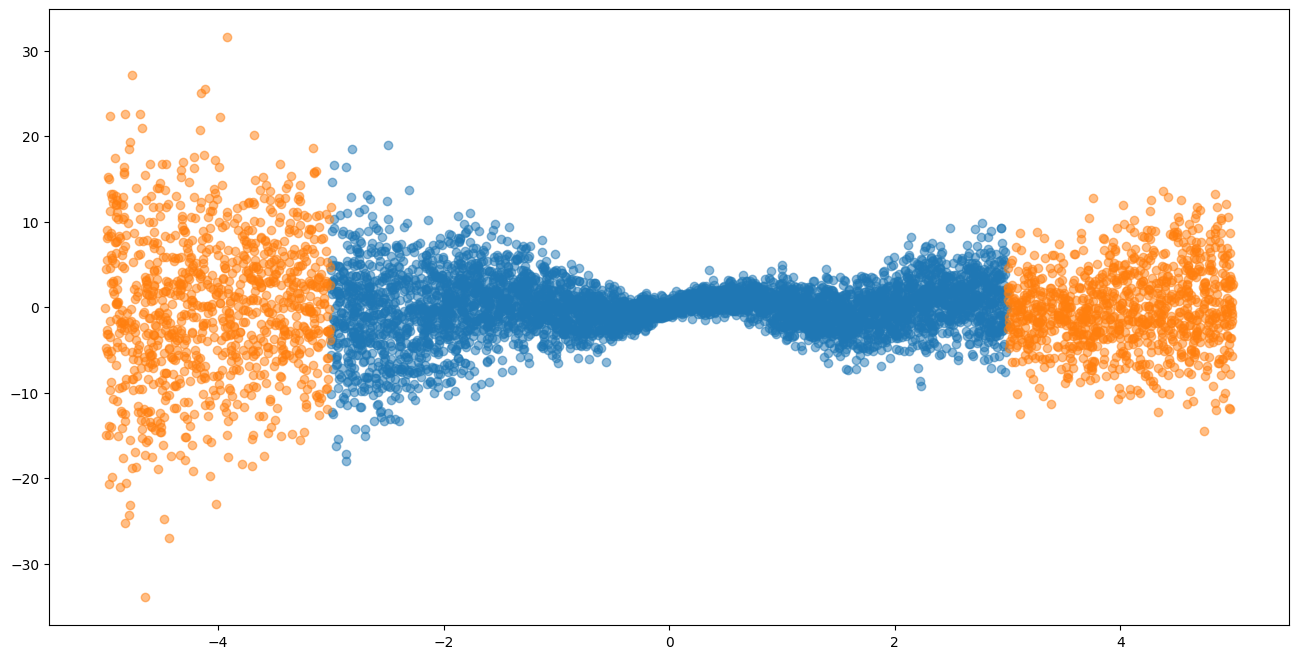

In [229]:
def mu(x):
    return np.sin(np.pi * x)


def sigma(x):
    return 0.5 + np.where(x > 0, 1, 2) * np.abs(x)


X = np.random.uniform(-3, 3, (5000, 1))
y = np.random.normal(mu(X), sigma(X))
X_out = np.concatenate([np.random.uniform(-5, -3, (1000, 1)), np.random.uniform(3, 5, (1000, 1))], 0)
y_out  = np.random.normal(mu(X_out), sigma(X_out))

plt.figure(figsize=(16, 8))
plt.scatter(X, y, alpha=0.5, color='tab:blue')
plt.scatter(X_out, y_out, alpha=0.5, color='tab:orange');

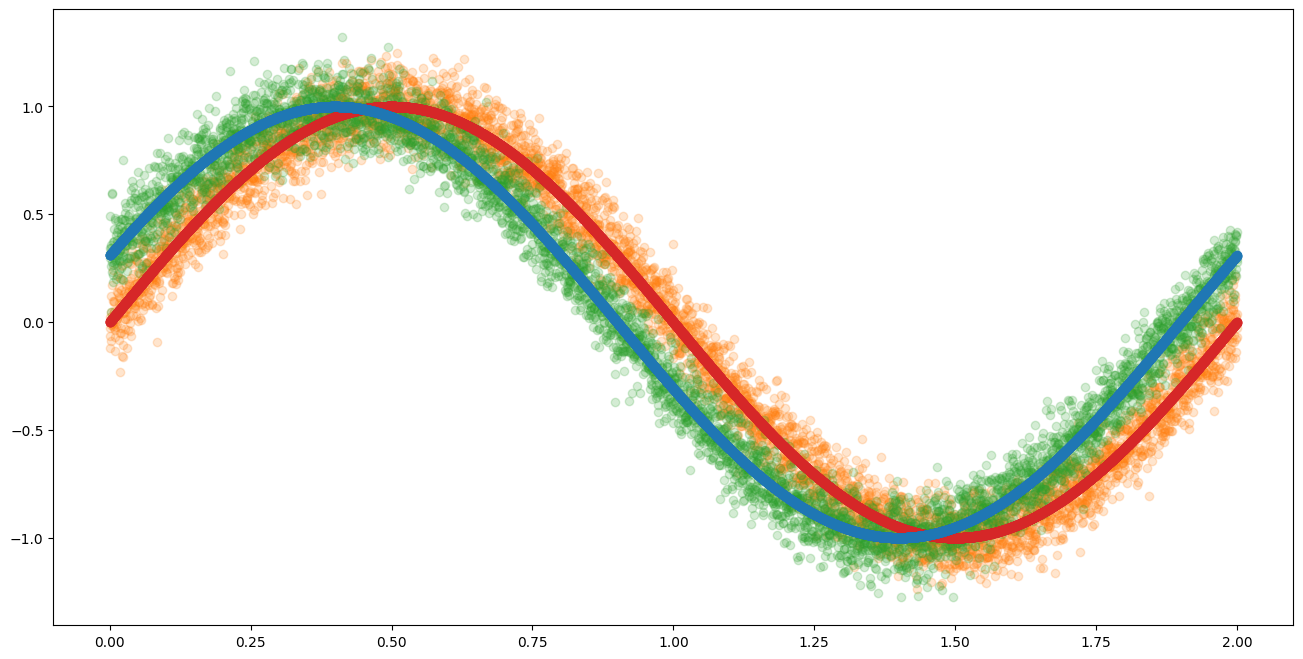

In [242]:
#My 2D attempt
def sin(x):
    return np.sin(np.pi * x)

#Create y as sine curves with 0.1 pi delay between them
y1=sin(np.linspace(0,2,5000)).reshape(-1,1)
y2=sin(np.linspace(0.1,2.1,5000)).reshape(-1,1)
y=np.concatenate((y1, y2), axis=1)
#Add N(0,0.1) noise to make X
sigma = 0.1*np.ones(np.shape(y))
X=np.random.normal(y,sigma)

xaxis=np.linspace(0,2,5000)

plt.figure(figsize=(16, 8))
plt.scatter(xaxis, X[:,0], alpha=0.2, color='tab:orange')
plt.scatter(xaxis, X[:,1], alpha=0.2, color='tab:green')
plt.scatter(xaxis, y[:,0], alpha=1, color='tab:red')
plt.scatter(xaxis, y[:,1], alpha=1, color='tab:blue');

#Divide train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

Then we define the quantile-loss function. The huber-like loss is preferable to the absolute error since it is differentiable

In [238]:
def QuantileLoss(perc, delta=1e-4):
    perc = np.array(perc).reshape(-1)
    perc.sort()
    perc = perc.reshape(1, -1)
    def _qloss(y, pred):
        I = tf.cast(y <= pred, tf.float32)
        d = K.abs(y - pred)
        correction = I * (1 - perc) + (1 - I) * perc
        # huber loss
        huber_loss = K.sum(correction * tf.where(d <= delta, 0.5 * d ** 2 / delta, d - 0.5 * delta), -1)
        # order loss
        q_order_loss = K.sum(K.maximum(0.0, pred[:, :-1] - pred[:, 1:] + 1e-6), -1)
        return huber_loss + q_order_loss
    return _qloss

In [328]:
#2D loss function attempt
def QuantileLoss2D(perc, delta=1e-4):
    perc = np.array(perc).reshape(-1)
    perc.sort()
    perc = perc.reshape(1, -1)
    def _qloss(y, pred):
        I = tf.cast(tf.repeat(y, tf.size(perc), axis=1) <= pred, tf.float32)
        d = K.abs(tf.repeat(y, tf.size(perc), axis=1) - pred)
        correction = I * (1 - tf.cast(tf.tile(perc, [1,tf.shape(y)[1]]),tf.float32)) + (1 - I) * tf.cast(tf.tile(perc, [1,tf.shape(y)[1]]),tf.float32)
        # huber loss
        huber_loss = K.sum(correction * tf.where(d <= delta, 0.5 * d ** 2 / delta, d - 0.5 * delta), -1)
        # order loss
        q_order_loss = K.sum(K.sum(K.maximum(0.0, tf.reshape(pred,[tf.shape(y)[0],-1,tf.size(perc)])[:, :,:-1] - tf.reshape(pred,[tf.shape(y)[0],-1,tf.size(perc)])[:, :,1:] + 1e-6), -1),-1)
        return huber_loss + q_order_loss
    return _qloss

In [341]:
perc_points = [0.1,0.5,0.9]
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
#    keras.layers.Dense(3,activation='linear')
    keras.layers.Dense(np.size(perc_points)*np.shape(y_train)[1],activation='linear')
])
#model.compile(optimizer=keras.optimizers.Adam(2e-3), loss=QuantileLoss(perc_points))
model.compile(optimizer=keras.optimizers.Adam(2e-3), loss=QuantileLoss2D(perc_points))
#model.fit(X, y, epochs=1, verbose=0)
model.fit(X_train, y_train, epochs=50, verbose=1, batch_size = 500)

Epoch 1/50


9/9 [==============================] - 6s 12ms/step - loss: 1.0862
Epoch 2/50
9/9 [==============================] - 0s 10ms/step - loss: 0.4459
Epoch 3/50
9/9 [==============================] - 0s 12ms/step - loss: 0.2714
Epoch 4/50
9/9 [==============================] - 0s 9ms/step - loss: 0.1894
Epoch 5/50
9/9 [==============================] - 0s 11ms/step - loss: 0.1503
Epoch 6/50
9/9 [==============================] - 0s 10ms/step - loss: 0.1370
Epoch 7/50
9/9 [==============================] - 0s 13ms/step - loss: 0.1329
Epoch 8/50
9/9 [==============================] - 0s 11ms/step - loss: 0.1301
Epoch 9/50
9/9 [==============================] - 0s 15ms/step - loss: 0.1294
Epoch 10/50
9/9 [==============================] - 0s 17ms/step - loss: 0.1271
Epoch 11/50
9/9 [==============================] - 0s 17ms/step - loss: 0.1265
Epoch 12/50
9/9 [==============================] - 0s 9ms/step - loss: 0.1254
Epoch 13/50
9/9 [==============================] - 0s 19ms/step - loss: 0.

In [344]:
y_pred = model.predict(X_test)
y_pred = np.reshape(y_pred,[-1,2,3])

mse = MSE(y_test,y_pred[:,:,1])

print(y_pred[250,1,2])
print(y_test[250,1])

mse

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 3ms/step
0.80458236
0.7608853249437807


0.006529839981649988

16/16 [==============================] - 0s 4ms/step


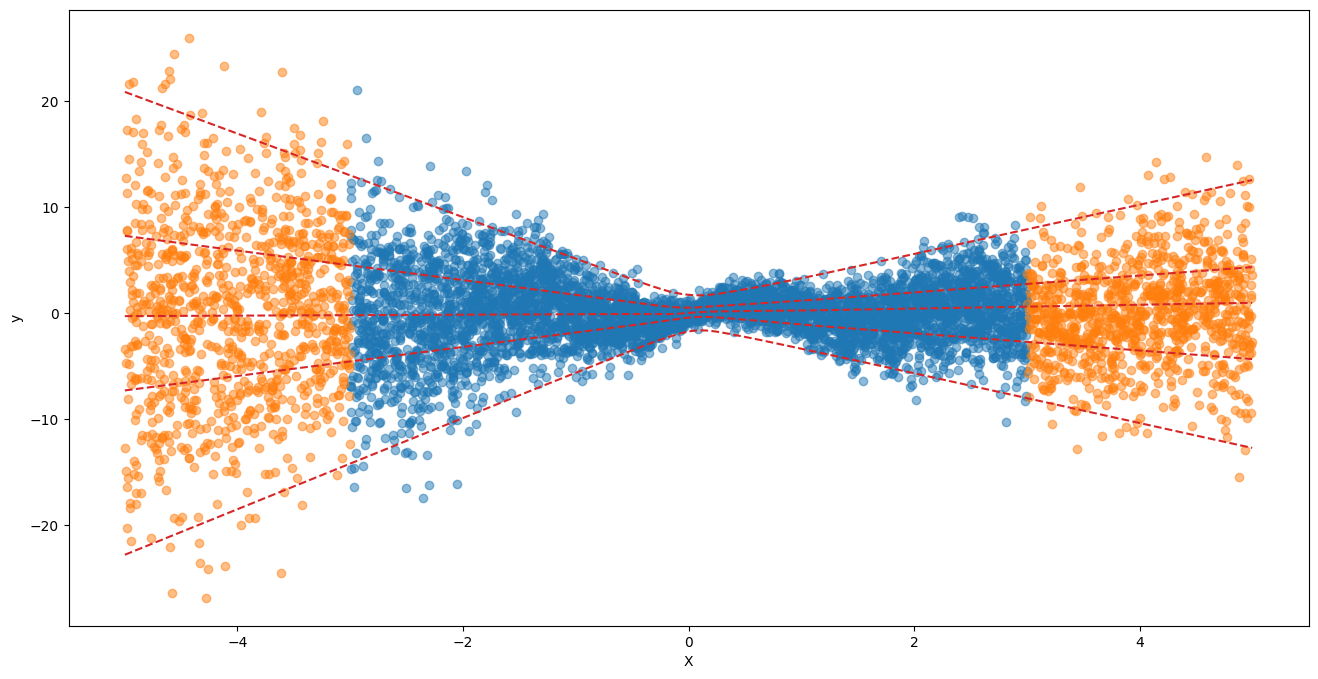

In [132]:
xx = np.linspace(X_out.min(), X_out.max(), 500)
pred = model.predict(xx)

plt.figure(figsize=(16, 8))
plt.scatter(X, y, alpha=0.5, color='tab:blue')
plt.scatter(X_out, y_out, alpha=0.5, color='tab:orange')
plt.plot(xx, pred, color='tab:red', linestyle='--')
plt.xlabel('X')
plt.ylabel('y');

Now we visualize the real cumulative distribution in various points VS the one estimated by the model

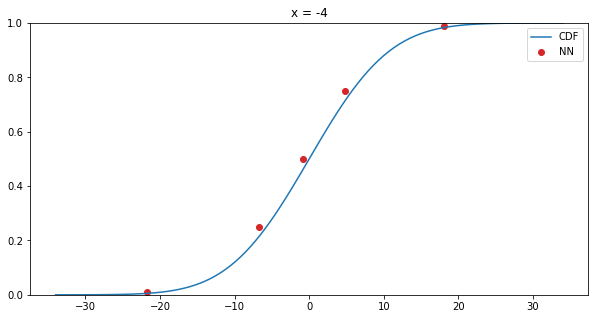

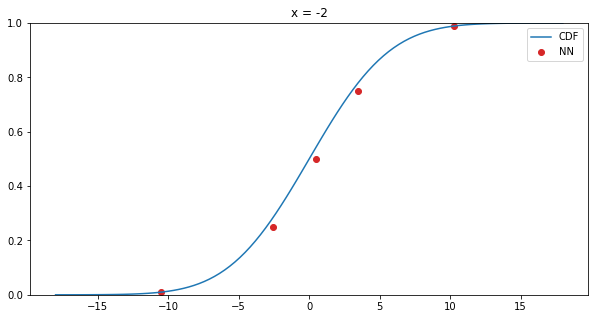

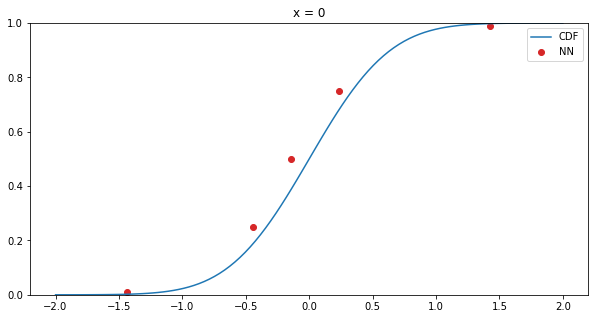

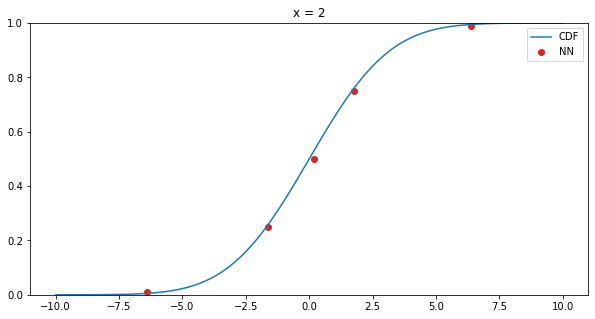

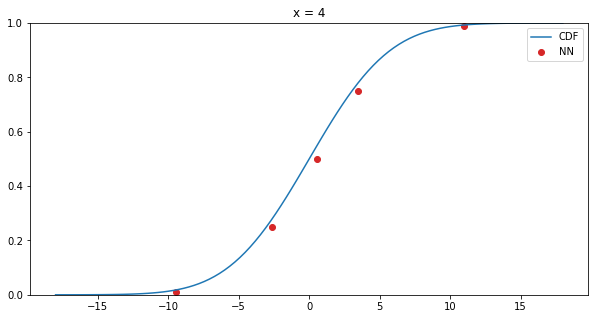

In [6]:
xs = np.array([-4, -2, 0, 2, 4]).reshape(-1, 1)
for i in range(xs.shape[0]):
    x0 = xs[i:(i + 1), :]
    mu0, sigma0 = mu(x0).squeeze(), sigma(x0).squeeze()
    z = np.linspace(mu0 - 4 * sigma0, mu0 + 4 * sigma0, 100)
    p = stats.norm(mu0, sigma0).cdf(z).reshape(-1)
    plt.figure(figsize=(10, 5))
    plt.plot(z, p, color='tab:blue', label='CDF')
    plt.scatter(model.predict(x0), perc_points, color='tab:red', label='NN')
    plt.title(f"x = {x0.squeeze()}")
    plt.legend()
    plt.ylim(0, 1)

In [31]:
#Order loss
A=np.array([[3,2,3,4,5,6]])
B=A[:,:-1]
C=A[:,1:]
tf.print(K.maximum(0.0, A[:, :-1] - A[:, 1:] + 1e-6))
tf.print(K.sum(K.maximum(0.0, A[:, :-1] - A[:, 1:] + 1e-6), -1))

[[1.00000095 0 0 0 0]]
[1.00000095]


In [156]:
#Huber loss multivariate
delta = 0.5
pred = np.array([[1,2,3,4,5],[6,7,8,9,10]])
perc = np.array([0.1, 0.25, 0.5, 0.75, 0.9])
y=np.array([[3.1],[8.1]])
#Find quantile over y identifyer
I = tf.cast(y <= pred, tf.float32)
print('I=')
tf.print(I)
#Find distances to y
d = K.abs(y - pred)
print('d=')
tf.print(d)
#Find correction matrix
correction = I * (1 - perc) + (1 - I) * perc
print('corr=')
tf.print(correction)
# huber loss
print('where term=')
tf.print(tf.where(d <= delta, 0.5 * d ** 2 / delta, d - 0.5 * delta))
huber_loss = K.sum(correction * tf.cast(tf.where(d <= delta, 0.5 * d ** 2 / delta, d - 0.5 * delta),dtype='float32'), -1)
print('huber loss =')
tf.print(huber_loss)


I=
[[0 0 0 1 1]
 [0 0 0 1 1]]
d=
[[2.1 1.1 0.10000000000000009 0.89999999999999991 1.9]
 [2.0999999999999996 1.0999999999999996 0.099999999999999645 0.90000000000000036 1.9000000000000004]]
corr=
[[0.1 0.25 0.5 0.25 0.1]
 [0.1 0.25 0.5 0.25 0.1]]
where term=
[[1.85 0.85000000000000009 0.010000000000000018 0.64999999999999991 1.65]
 [1.8499999999999996 0.84999999999999964 0.0099999999999999291 0.65000000000000036 1.6500000000000004]]
huber loss =
[0.73 0.73]


In [172]:
#Huber loss multivariate
delta = 0.5
pred=np.zeros([2,2,3])
pred[:,:,0]=np.array([[1,6],[1,6]])
pred[:,:,1]=np.array([[3,8],[3,8]])
pred[:,:,2]=np.array([[5,10],[5,10]])
perc = np.array([0.1, 0.5, 0.9]).reshape(1,-1)
y=np.array([[3.1,8.1],[3.2,8.2]])
#Find quantile over y identifyer
I = tf.cast(y[:,:,None] <= pred, tf.float32)
print('I=')
tf.print(I)
#Find distances to y
d = K.abs(y[:,:,None] - pred)
print('d=')
tf.print(d)
#Find correction matrix
correction = I * (1 - perc) + (1 - I) * perc
print('corr=')
tf.print(correction)
# huber loss
print('where term=')
tf.print(tf.where(d <= delta, 0.5 * d ** 2 / delta, d - 0.5 * delta))
huber_loss = K.sum(correction * tf.cast(tf.where(d <= delta, 0.5 * d ** 2 / delta, d - 0.5 * delta),dtype='float32'), -1)
print('huber loss =')
tf.print(huber_loss)


I=
[[[0 0 1]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]]
d=
[[[2.1 0.10000000000000009 1.9]
  [2.0999999999999996 0.099999999999999645 1.9000000000000004]]

 [[2.2 0.20000000000000018 1.7999999999999998]
  [2.1999999999999993 0.19999999999999929 1.8000000000000007]]]
corr=
[[[0.1 0.5 0.1]
  [0.1 0.5 0.1]]

 [[0.1 0.5 0.1]
  [0.1 0.5 0.1]]]
where term=
[[[1.85 0.010000000000000018 1.65]
  [1.8499999999999996 0.0099999999999999291 1.6500000000000004]]

 [[1.9500000000000002 0.04000000000000007 1.5499999999999998]
  [1.9499999999999993 0.039999999999999716 1.5500000000000007]]]
huber loss =
[[0.355000019 0.355000019]
 [0.37 0.37]]


In [169]:


y=np.array([[3.1,8.1],[3.2,8.2]])
print(np.shape(y))

prop=np.zeros([2,2,3])
prop[:,:,0]=np.array([[1,6],[1,6]])
prop[:,:,1]=np.array([[3,8],[3,8]])
prop[:,:,2]=np.array([[5,10],[5,10]])
print(np.shape(prop))
print(prop[:,:,2])

prop2=np.zeros([2,2,3])
prop2[:,:,0]=np.array([[2,6],[1,6]])
prop2[:,:,1]=np.array([[4,8],[3,8]])
prop2[:,:,2]=np.array([[6,10],[5,10]])
I=prop2>prop
print(I[:,:,2])

y3d=np.dstack([y,y,y])
print(np.shape(y3d))
print(y3d[:,:,1])

(2, 2)
(2, 2, 3)
[[ 5. 10.]
 [ 5. 10.]]
[[ True False]
 [False False]]
(2, 2, 3)
[[3.1 8.1]
 [3.2 8.2]]


In [199]:
 # order loss
pred = np.array([[1,2,3,4,5],[6,7,8,9,10]])
prop=np.zeros([2,2,3])
prop[:,:,0]=np.array([[1,6],[1,6]])
prop[:,:,1]=np.array([[3,8],[3,8]])
prop[:,:,2]=np.array([[5,10],[5,10]])

q_order_loss = K.sum(K.maximum(0.0, prop[:, :,:-1] - prop[:, :,1:] + 1e-6), -1)
tf.print(prop[:,:,:-1])
tf.print(q_order_loss)

array([[[4., 3.],
        [6., 8.]],

       [[1., 3.],
        [6., 8.]]])
[[1.00000095 0]
 [0 0]]


In [227]:
A=[1,2,3]
np.size(A)

3

In [268]:
A=np.array([[1,2,3,1,2,3,1,2,3],[1,2,3,1,2,3,1,2,3]])
B=np.reshape(A,[2,3,3])
print(B[:,:,2])

[[3 3 3]
 [3 3 3]]


In [324]:
pred = np.array([[2.1,2,3,1,2,3],[2,3,4,2,3,4]])
#pred = tf.cast(tf.reshape(pred,[2,-1,3]),tf.float32)
#print(pred[:,:,0])
q_order_loss = K.sum(K.sum(K.maximum(0.0, tf.reshape(pred,[2,-1,3])[:, :,:-1] - tf.reshape(pred,[2,-1,3])[:, :,1:] + 1e-6), -1),-1)

print(q_order_loss)

tf.Tensor([0.100001 0.      ], shape=(2,), dtype=float64)
